In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import lmfit
import pprint
import os

mat = scipy.io.loadmat('Matlab.mat')

list(mat)

['__header__',
 '__version__',
 '__globals__',
 'F\x00\x00\x00\x00\x00\x00\x00',
 'S\x00\x00\x00\x00\x00\x00\x00']

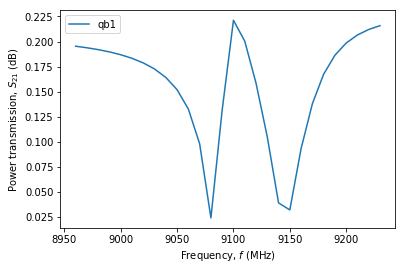

In [2]:
F = mat['F\x00\x00\x00\x00\x00\x00\x00']
S = mat['S\x00\x00\x00\x00\x00\x00\x00']

dataset_all = {'qb1': (F[0], S[1][0])}

datarange = {'qb1': (9.0e9, 9.2e9)}

datarange = {qb: (r[0] - 40e6, r[1] + 40e6) for qb, r in datarange.items()}
filterdatax = lambda f, s, r: (f[(f >= r[0])*(f < r[1])], s[(f >= r[0])*(f < r[1])])
dataset = {qb: filterdatax(*dataset_all[qb], datarange[qb]) for qb in dataset_all}

for qb in ['qb1']:
    f, s = dataset[qb]
    plt.plot(f/1e6, np.abs(s), label=qb)
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Power transmission, $S_{21}$ (dB)')
    plt.legend()
    plt.show()

In [3]:
f

array([8.96e+09, 8.97e+09, 8.98e+09, 8.99e+09, 9.00e+09, 9.01e+09,
       9.02e+09, 9.03e+09, 9.04e+09, 9.05e+09, 9.06e+09, 9.07e+09,
       9.08e+09, 9.09e+09, 9.10e+09, 9.11e+09, 9.12e+09, 9.13e+09,
       9.14e+09, 9.15e+09, 9.16e+09, 9.17e+09, 9.18e+09, 9.19e+09,
       9.20e+09, 9.21e+09, 9.22e+09, 9.23e+09])

In [4]:
s

array([ 0.18681905+0.0569232j ,  0.18635747+0.05302206j,
        0.18562491+0.04862021j,  0.18452102+0.04361645j,
        0.1828981 +0.03788207j,  0.1805319 +0.03125216j,
        0.17706884+0.02351536j,  0.17192457+0.01440586j,
        0.16407398+0.00361539j,  0.15157703-0.00909603j,
        0.13040186-0.02331083j,  0.091416  -0.03473313j,
        0.01791845-0.015561j  , -0.01450698+0.13082911j,
        0.15382436+0.15902838j,  0.19131092+0.05964207j,
        0.1583791 -0.00501654j,  0.09882878-0.03459295j,
        0.03074903-0.02353006j, -0.01788499+0.0262023j ,
       -0.02843044+0.08859254j, -0.01030451+0.13739131j,
        0.01790085+0.16637999j,  0.04531666+0.1806799j ,
        0.06845348+0.18631052j,  0.08708023+0.18729286j,
        0.10191676+0.18591361j,  0.1137872 +0.18340443j])

In [5]:
def fit_and_plot_complex(freq, s21, plotfit=True, plotguess=True, label=None, plot_filename=None, **guessvals):
    def s21func(x, A, phi, kP, gR, wR, wP, J, tau, k, phi0): 
        y = (A + k*(x-np.mean(x)))*np.exp(1j*tau*x + 1j*phi0)*(np.cos(phi) - np.exp(1j*phi)*kP*(gR-2j*(x-wR))/(4*J*J+(kP-2j*(x-wP))*(gR-2j*(x-wR))))
        return np.concatenate((np.real(y), np.imag(y)))
    model = lmfit.Model(s21func)
    def_guessvals = dict(
        A=0.5,
        phi=-0.6,
        kP=50.8,
        gR=0.5,
        wR=np.mean(freq),
        wP=np.mean(freq),
        J=12,
        tau=np.median(np.diff(np.angle(s21)))/np.median(np.diff(freq)),
        k=0,
        phi0=0,
    )
    def_guessvals.update(guessvals)
    pars = model.make_params(**def_guessvals)
    pars['kP'].min = 0
    pars['gR'].min = 0
    pars['J'].min = 0
    pars['wP'].min = freq.min()
    pars['wR'].min = freq.min()
    pars['wP'].max = freq.max()
    pars['wR'].max = freq.max()
    fit = model.fit(np.concatenate((np.real(s21), np.imag(s21))), x=freq, params=pars)
    s21fit = fit.best_fit[:len(freq)] + 1j*fit.best_fit[len(freq):]
    s21guess = s21func(freq, **def_guessvals)
    s21guess = s21guess[:len(freq)] + 1j*s21guess[len(freq):]
    
    plt.subplot(121)
    plt.plot(freq, np.abs(s21), label=label)
    if plotfit: plt.plot(freq, np.abs(s21fit))
    if plotguess: plt.plot(freq, np.abs(s21guess))
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Transmission amplitude, $|S_{21}|$')
    if label is not None: plt.legend()
    plt.subplot(122)
    plt.plot(freq, np.angle(s21))
    if plotfit: plt.plot(freq, np.angle(s21fit), 'r-',linewidth=1, label='Lorentzian fit')
    if plotguess: plt.plot(freq, np.angle(s21guess),'k--',  linewidth=2, label='Simulation')
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Transmission angle, $\\mathrm{arg}(S_{21})$')
    
    plt.gcf().set_size_inches(9,3)
    if plot_filename is not None: plt.savefig(plot_filename, bbox_inches='tight')
    plt.show()

    
    return fit, s21fit

def fit_and_plot_abs(freq, s21, plotfit=True, plotguess=True, label=None, plot_filename=True, **guessvals):
    def s21func(x, A, phi, kP, gR, wR, wP, J, k): 
        y = (A + k*(x-np.mean(x)))*np.abs(np.cos(phi) - np.exp(1j*phi)*kP*(gR-2j*(x-wR))/(4*J*J+(kP-2j*(x-wP))*(gR-2j*(x-wR))))
        return y
    model = lmfit.Model(s21func)
    def_guessvals = dict(
        A=0.5,
        phi=-0.6,
        kP=50.8,
        gR=0.5,
        wR=np.mean(freq),
        wP=np.mean(freq),
        J=12,
        k=0,
    )
    def_guessvals.update(guessvals)
    pars = model.make_params(**def_guessvals)
    pars['kP'].min = 0
    pars['gR'].min = 0
    pars['J'].min = 0
    pars['wP'].min = freq.min()
    pars['wR'].min = freq.min()
    pars['wP'].max = freq.max()
    pars['wR'].max = freq.max()
    fit = model.fit(np.abs(s21), x=freq, params=pars)
    s21fit = fit.best_fit
    s21guess = s21func(freq, **def_guessvals)
    
    plt.plot(freq, np.abs(s21),'k--',  linewidth=1.2, label=label)
    if plotfit: plt.plot(freq,s21fit, 'r-',linewidth=0.8, label='Fit')
    if plotguess: plt.plot(freq, s21guess,'k--',  linewidth=2, label='Simulation')
    plt.xlabel('Frequency, $f$ [MHz]')
    plt.ylabel('Normalized transmission\n amplitude, $|S_{21}|/ \\mathrm{max}(|S_{21}|)$')
    if label is not None: plt.legend()
#     plt.gcf().set_size_inches(4.5,3)
    if plot_filename is not None: plt.savefig(plot_filename+'.pdf', bbox_inches='tight')
    plt.show()

    
    return fit, s21fit

In [6]:
my_params = {
'figure.dpi':  120,
'figure.figsize': [4,2], # [4,3]
'figure.subplot.left' : 0.15,
'figure.subplot.right'      : 0.9,
'figure.subplot.bottom'     : 0.12,
'axes.titlesize'    : 'medium',
'axes.labelsize'    : 10.0 ,
'xtick.direction' : 'in',
'ytick.direction' : 'in',
'ytick.labelsize'   :'small',
'xtick.labelsize'   :'small',
'legend.fontsize'   : 8,  #small,
'legend.loc'        : 'best',
'font.size'         : 10.0,
'font.family'       : 'serif',
'text.usetex' : False,    # if you have latex
}

guessvals = {
    'qb1': {'A': 1,
            'J': 25,
            'gR': 1,
            'k': 0.1,
            'kP': 50,
            'phi': 25,
            'wP': 9060,
            'wR': 9150}  
}


datatransform = lambda f, s: (f/1e6, s/np.abs(s).max())




qb1


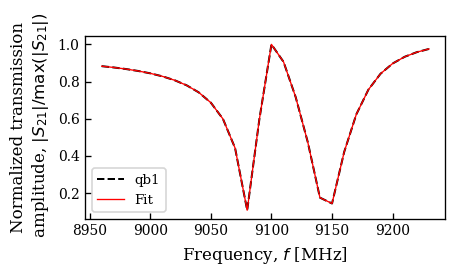

{'A': 1.0021194392250763,
 'J': 30.29093811930018,
 'gR': 0.0343660669677579,
 'k': 0.00010213604380630143,
 'kP': 93.16508120987126,
 'phi': 25.32557462310137,
 'wP': 9132.283367958977,
 'wR': 9104.236098771175}


In [7]:
bestvals = {}


plt.rcParams.update(my_params)


for qb in dataset:
    print(f'\n\n\n{qb}')
    fit, s21fit = fit_and_plot_abs(*datatransform(*dataset[qb]), **guessvals[qb], plotguess=False, label=qb, plot_filename=qb+'.png')
    
    pprint.pprint(fit.best_values)
    bestvals[qb] = fit.best_values